# 03 - DataLoader e Data Augmentation

Questo notebook implementa:
1. Caricamento della configurazione da file YAML
2. Dataset PyTorch personalizzato per le immagini retiniche
3. Pipeline di Data Augmentation con Albumentations
4. DataLoader con gestione del class imbalance
5. Visualizzazione delle augmentation

## 1. Import e Configurazione

In [21]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Manipolazione dati
import pandas as pd
import numpy as np

# Configurazione
import yaml

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Elaborazione immagini
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Visualizzazione
import matplotlib.pyplot as plt

# Impostazioni
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponibile: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu130
CUDA disponibile: True


In [22]:
# Funzione per trovare la root del progetto
def get_project_root():
    """Rileva la root del progetto."""
    notebook_dir = Path.cwd()
    if notebook_dir.name == 'notebooks':
        return notebook_dir.parent
    current = notebook_dir
    for _ in range(5):
        if (current / 'Data').exists():
            return current
        current = current.parent
    if sys.platform == 'linux' and Path('/mnt/c').exists():
        return Path('/mnt/c/Repository/multi-method-xai-diabetic-retinopathy')
    return Path('C:/Repository/multi-method-xai-diabetic-retinopathy')

PROJECT_ROOT = get_project_root()
print(f"Project root: {PROJECT_ROOT}")

Project root: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy


In [23]:
# Caricamento configurazione da YAML
config_path = PROJECT_ROOT / 'config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Configurazione caricata:")
print(f"  - Batch size: {config['dataloader']['batch_size']}")
print(f"  - Num workers: {config['dataloader']['num_workers']}")
print(f"  - Target size: {config['preprocessing']['target_size']}")
print(f"  - Use class weights: {config['training']['use_class_weights']}")

Configurazione caricata:
  - Batch size: 16
  - Num workers: 4
  - Target size: 456
  - Use class weights: True


In [24]:
# Setup percorsi
DATA_DIR = PROJECT_ROOT / config['paths']['data_dir']
PROCESSED_DIR = PROJECT_ROOT / config['paths']['processed_dir']
PREPROCESSED_DIR = PROJECT_ROOT / config['paths']['preprocessed_images']
RESULTS_DIR = PROJECT_ROOT / config['paths']['results_dir']

# Seed per riproducibilita
SEED = config['seed']
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Seed impostato: {SEED}")

Seed impostato: 42


## 2. Caricamento CSV Preprocessati

In [25]:
# Carica i CSV con i percorsi delle immagini preprocessate
train_df = pd.read_csv(PROCESSED_DIR / 'combined_train_preprocessed.csv')
val_df = pd.read_csv(PROCESSED_DIR / 'aptos_preprocessed.csv')
val_df = val_df[val_df['split'] == 'valid']  # Solo validation set APTOS

test_df = pd.read_csv(PROCESSED_DIR / 'messidor2_preprocessed.csv')

print("Dataset caricati:")
print(f"  Train: {len(train_df)} immagini")
print(f"  Validation: {len(val_df)} immagini")
print(f"  Test (Messidor-2): {len(test_df)} immagini")

Dataset caricati:
  Train: 38056 immagini
  Validation: 366 immagini
  Test (Messidor-2): 1744 immagini


In [26]:
# Verifica distribuzione classi nel training set
print("\nDistribuzione classi - Training set:")
class_counts = train_df['diagnosis'].value_counts().sort_index()
class_names = config['model']['class_names']

for cls, count in class_counts.items():
    pct = count / len(train_df) * 100
    print(f"  Classe {cls} ({class_names[cls]}): {count:,} ({pct:.1f}%)")


Distribuzione classi - Training set:
  Classe 0 (No DR): 27,244 (71.6%)
  Classe 1 (Mild): 2,743 (7.2%)
  Classe 2 (Moderate): 6,100 (16.0%)
  Classe 3 (Severe): 1,027 (2.7%)
  Classe 4 (Proliferative): 942 (2.5%)


## 3. Pipeline di Data Augmentation

In [27]:
def get_train_transforms(cfg):
    """
    Crea la pipeline di augmentation per il training.
    
    Trasformazioni applicate:
    - Flip orizzontale e verticale
    - Rotazione
    - Variazioni di luminosita, contrasto, saturazione
    - Blur e rumore (con bassa probabilita)
    - Normalizzazione ImageNet
    """
    aug_cfg = cfg['augmentation']
    target_size = cfg['preprocessing']['target_size']
    
    return A.Compose([
        # Trasformazioni geometriche
        A.HorizontalFlip(p=0.5 if aug_cfg['horizontal_flip'] else 0),
        A.VerticalFlip(p=0.5 if aug_cfg['vertical_flip'] else 0),
        A.Rotate(
            limit=aug_cfg['rotation_limit'],
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            p=aug_cfg['prob_geometric']
        ),
        
        # Trasformazioni di colore
        A.OneOf([
            A.RandomBrightnessContrast(
                brightness_limit=aug_cfg['brightness_limit'],
                contrast_limit=aug_cfg['contrast_limit'],
                p=1.0
            ),
            A.HueSaturationValue(
                hue_shift_limit=aug_cfg['hue_shift_limit'],
                sat_shift_limit=int(aug_cfg['saturation_limit'] * 100),
                val_shift_limit=int(aug_cfg['brightness_limit'] * 100),
                p=1.0
            ),
        ], p=aug_cfg['prob_color']),
        
        # Blur (bassa probabilita)
        A.GaussianBlur(
            blur_limit=aug_cfg['blur_limit'],
            p=aug_cfg['prob_blur']
        ),
        
        # Rumore (bassa probabilita)
        A.GaussNoise(
            var_limit=aug_cfg['noise_var_limit'],
            p=aug_cfg['prob_noise']
        ),
        
        # Normalizzazione ImageNet
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        
        # Conversione a tensore PyTorch
        ToTensorV2()
    ])


def get_val_transforms(cfg):
    """
    Crea la pipeline per validation/test (solo normalizzazione).
    """
    return A.Compose([
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])


# Crea le trasformazioni
train_transforms = get_train_transforms(config)
val_transforms = get_val_transforms(config)

print("Pipeline di augmentation create.")

Pipeline di augmentation create.


## 4. Dataset PyTorch

In [28]:
class DRDataset(Dataset):
    """
    Dataset PyTorch per la classificazione della Retinopatia Diabetica.
    
    Args:
        dataframe: DataFrame con colonne 'preprocessed_path' e 'diagnosis'
        transform: Pipeline di trasformazioni Albumentations
        project_root: Path alla root del progetto (per convertire percorsi relativi)
    """
    
    def __init__(self, dataframe, transform=None, project_root=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.project_root = project_root
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Costruisci il percorso dell'immagine
        img_path = row['preprocessed_path']
        
        # Se il percorso e relativo, aggiungi la root
        if self.project_root and not Path(img_path).is_absolute():
            img_path = self.project_root / img_path
        
        # Carica l'immagine
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Applica le trasformazioni
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        # Label
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        
        return image, label
    
    def get_labels(self):
        """Ritorna tutte le label (utile per il weighted sampler)."""
        return self.df['diagnosis'].values


print("Classe DRDataset definita.")

Classe DRDataset definita.


In [29]:
# Crea i dataset
train_dataset = DRDataset(train_df, transform=train_transforms, project_root=PROJECT_ROOT)
val_dataset = DRDataset(val_df, transform=val_transforms, project_root=PROJECT_ROOT)
test_dataset = DRDataset(test_df, transform=val_transforms, project_root=PROJECT_ROOT)

print(f"Dataset creati:")
print(f"  Train: {len(train_dataset)} campioni")
print(f"  Validation: {len(val_dataset)} campioni")
print(f"  Test: {len(test_dataset)} campioni")

Dataset creati:
  Train: 38056 campioni
  Validation: 366 campioni
  Test: 1744 campioni


## 5. Gestione Class Imbalance

In [30]:
def compute_class_weights(labels):
    """
    Calcola i pesi delle classi per bilanciare la loss.
    
    Formula: weight[c] = n_samples / (n_classes * n_samples[c])
    """
    class_counts = np.bincount(labels)
    n_samples = len(labels)
    n_classes = len(class_counts)
    
    weights = n_samples / (n_classes * class_counts)
    return torch.FloatTensor(weights)


def create_weighted_sampler(labels):
    """
    Crea un WeightedRandomSampler per il bilanciamento durante il training.
    
    Ogni campione ha una probabilita di essere selezionato inversamente
    proporzionale alla frequenza della sua classe.
    """
    class_counts = np.bincount(labels)
    class_weights = 1.0 / class_counts
    
    # Peso per ogni campione basato sulla sua classe
    sample_weights = class_weights[labels]
    sample_weights = torch.DoubleTensor(sample_weights)
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

In [31]:
# Calcola i pesi delle classi
train_labels = train_dataset.get_labels()
class_weights = compute_class_weights(train_labels)

print("Pesi delle classi per la loss:")
for i, w in enumerate(class_weights):
    print(f"  Classe {i} ({class_names[i]}): {w:.4f}")

Pesi delle classi per la loss:
  Classe 0 (No DR): 0.2794
  Classe 1 (Mild): 2.7748
  Classe 2 (Moderate): 1.2477
  Classe 3 (Severe): 7.4111
  Classe 4 (Proliferative): 8.0798


In [32]:
# Crea il weighted sampler (alternativa ai class weights)
if config['training']['use_oversampling']:
    train_sampler = create_weighted_sampler(train_labels)
    shuffle_train = False  # Non si puo usare shuffle con sampler
    print("Weighted sampler creato per oversampling.")
else:
    train_sampler = None
    shuffle_train = config['dataloader']['shuffle_train']
    print("Uso class weights nella loss (no oversampling).")

Uso class weights nella loss (no oversampling).


## 6. Creazione DataLoader

In [33]:
# Parametri DataLoader
batch_size = config['dataloader']['batch_size']
num_workers = config['dataloader']['num_workers']
pin_memory = config['dataloader']['pin_memory'] and torch.cuda.is_available()

# Crea i DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=shuffle_train,
    sampler=train_sampler,
    num_workers=num_workers,
    pin_memory=pin_memory,
    drop_last=True  # Evita batch incompleti
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

print(f"DataLoader creati:")
print(f"  Train: {len(train_loader)} batch (batch_size={batch_size})")
print(f"  Validation: {len(val_loader)} batch")
print(f"  Test: {len(test_loader)} batch")

DataLoader creati:
  Train: 2378 batch (batch_size=16)
  Validation: 23 batch
  Test: 109 batch


## 7. Visualizzazione Augmentation

In [34]:
def denormalize(tensor):
    """
    Denormalizza un tensore ImageNet per visualizzazione.
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean


def show_augmented_samples(dataset, n_samples=4, n_augmentations=4):
    """
    Mostra lo stesso campione con diverse augmentation.
    """
    fig, axes = plt.subplots(n_samples, n_augmentations + 1, figsize=(16, 4 * n_samples))
    
    # Seleziona campioni casuali (uno per classe se possibile)
    sample_indices = []
    for cls in range(min(n_samples, 5)):
        cls_indices = dataset.df[dataset.df['diagnosis'] == cls].index.tolist()
        if cls_indices:
            sample_indices.append(np.random.choice(cls_indices))
    
    # Riempi se necessario
    while len(sample_indices) < n_samples:
        sample_indices.append(np.random.randint(0, len(dataset)))
    
    for row, idx in enumerate(sample_indices):
        # Immagine originale (senza augmentation)
        row_data = dataset.df.iloc[idx]
        img_path = row_data['preprocessed_path']
        if dataset.project_root and not Path(img_path).is_absolute():
            img_path = dataset.project_root / img_path
        
        original = cv2.imread(str(img_path))
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        
        axes[row, 0].imshow(original)
        axes[row, 0].set_title(f'Originale\nClasse {row_data["diagnosis"]}: {class_names[row_data["diagnosis"]]}')
        axes[row, 0].axis('off')
        
        # Diverse augmentation
        for col in range(1, n_augmentations + 1):
            img, label = dataset[idx]
            img_denorm = denormalize(img)
            img_np = img_denorm.permute(1, 2, 0).numpy()
            img_np = np.clip(img_np, 0, 1)
            
            axes[row, col].imshow(img_np)
            axes[row, col].set_title(f'Augmentation {col}')
            axes[row, col].axis('off')
    
    plt.suptitle('Esempi di Data Augmentation', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

Figura salvata in: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/results/augmentation_examples.png


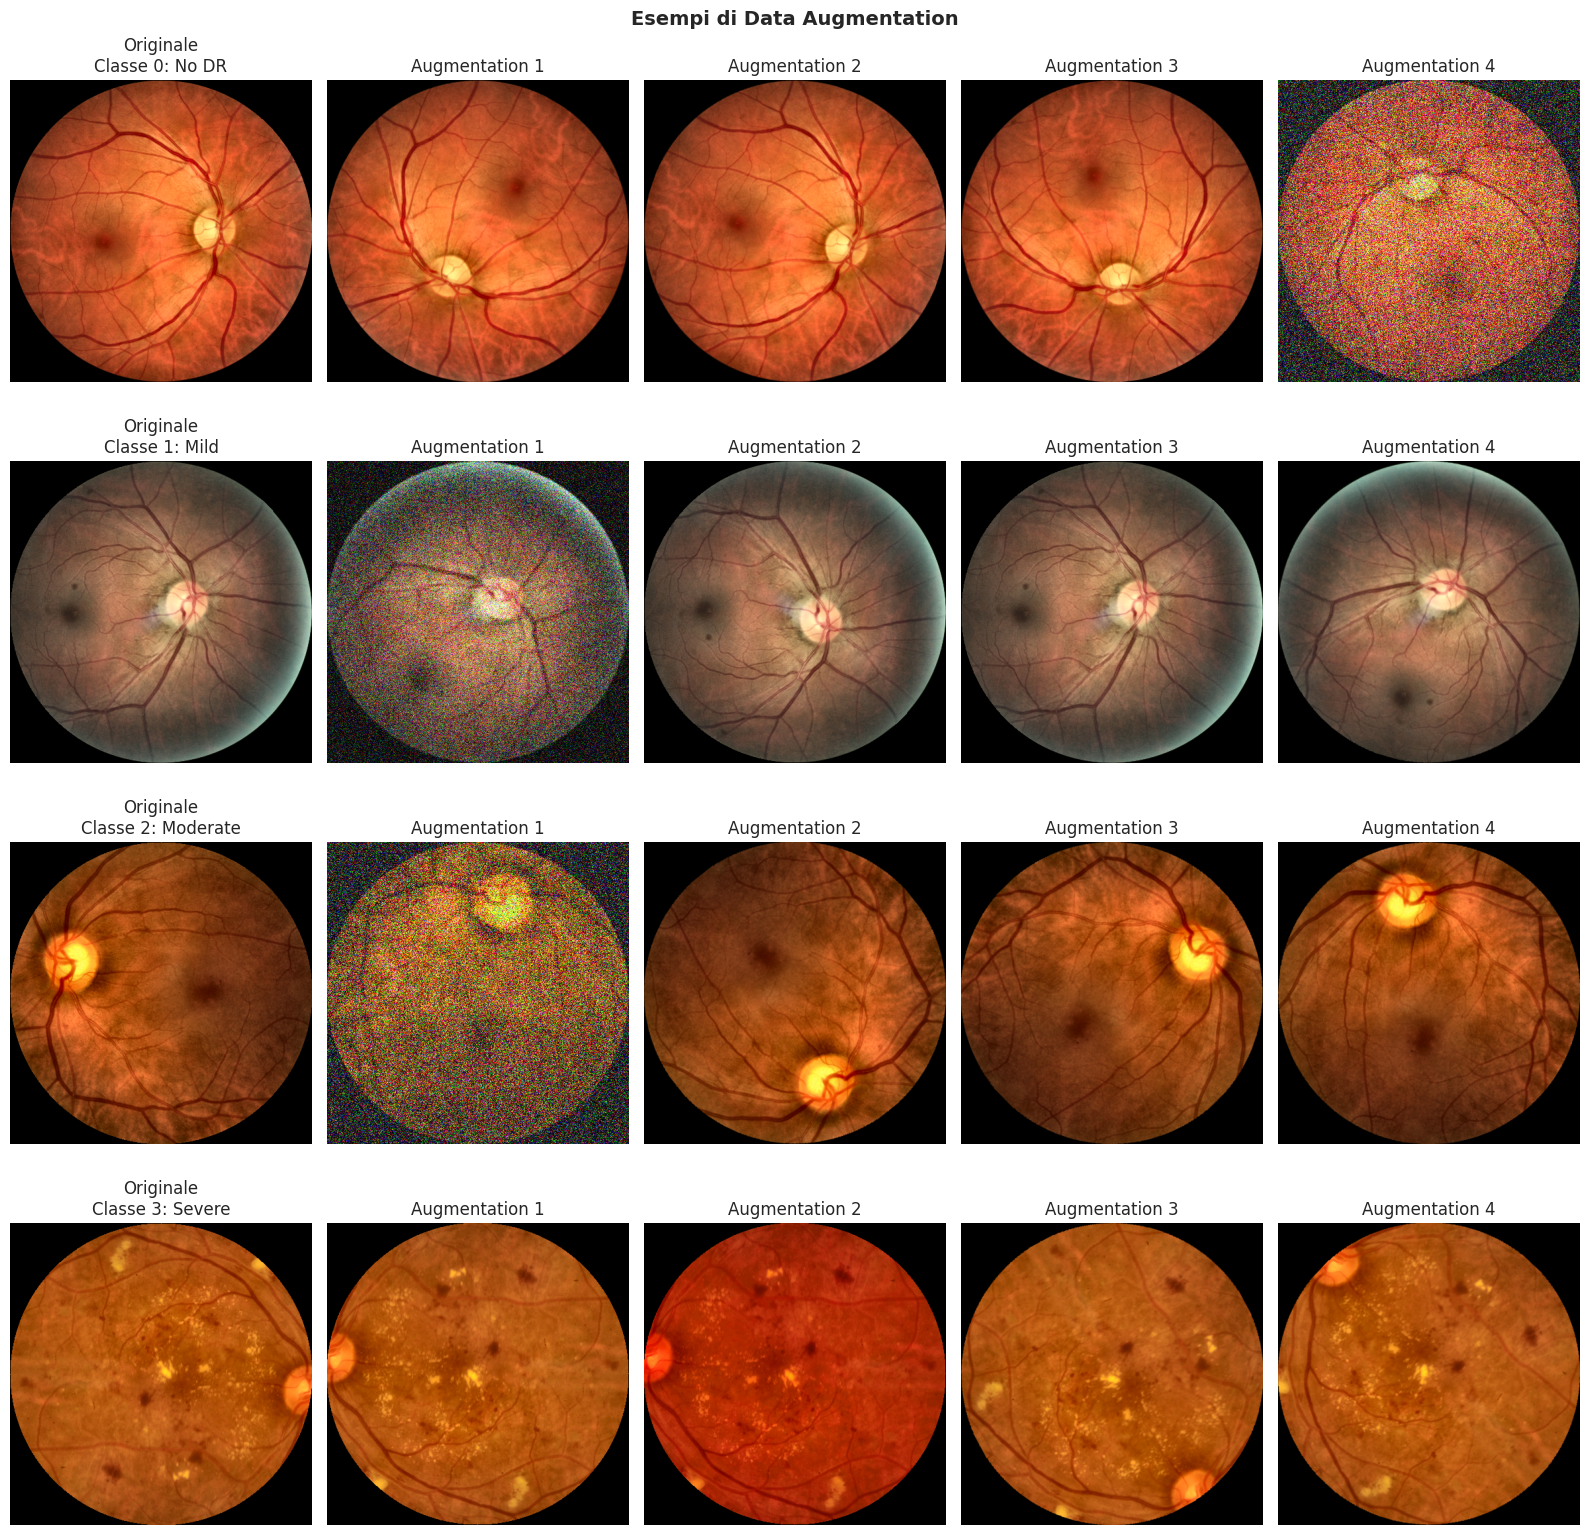

In [35]:
# Visualizza le augmentation
fig = show_augmented_samples(train_dataset, n_samples=4, n_augmentations=4)

# Salva la figura
output_path = RESULTS_DIR / 'augmentation_examples.png'
fig.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Figura salvata in: {output_path}")
plt.show()

## 8. Test del DataLoader

In [36]:
# Test: carica un batch
batch_images, batch_labels = next(iter(train_loader))

print(f"Batch di training:")
print(f"  Shape immagini: {batch_images.shape}")
print(f"  Shape labels: {batch_labels.shape}")
print(f"  Dtype immagini: {batch_images.dtype}")
print(f"  Range valori: [{batch_images.min():.3f}, {batch_images.max():.3f}]")
print(f"  Labels nel batch: {batch_labels.tolist()}")

Batch di training:
  Shape immagini: torch.Size([16, 3, 456, 456])
  Shape labels: torch.Size([16])
  Dtype immagini: torch.float32
  Range valori: [-2.118, 2.640]
  Labels nel batch: [2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0]


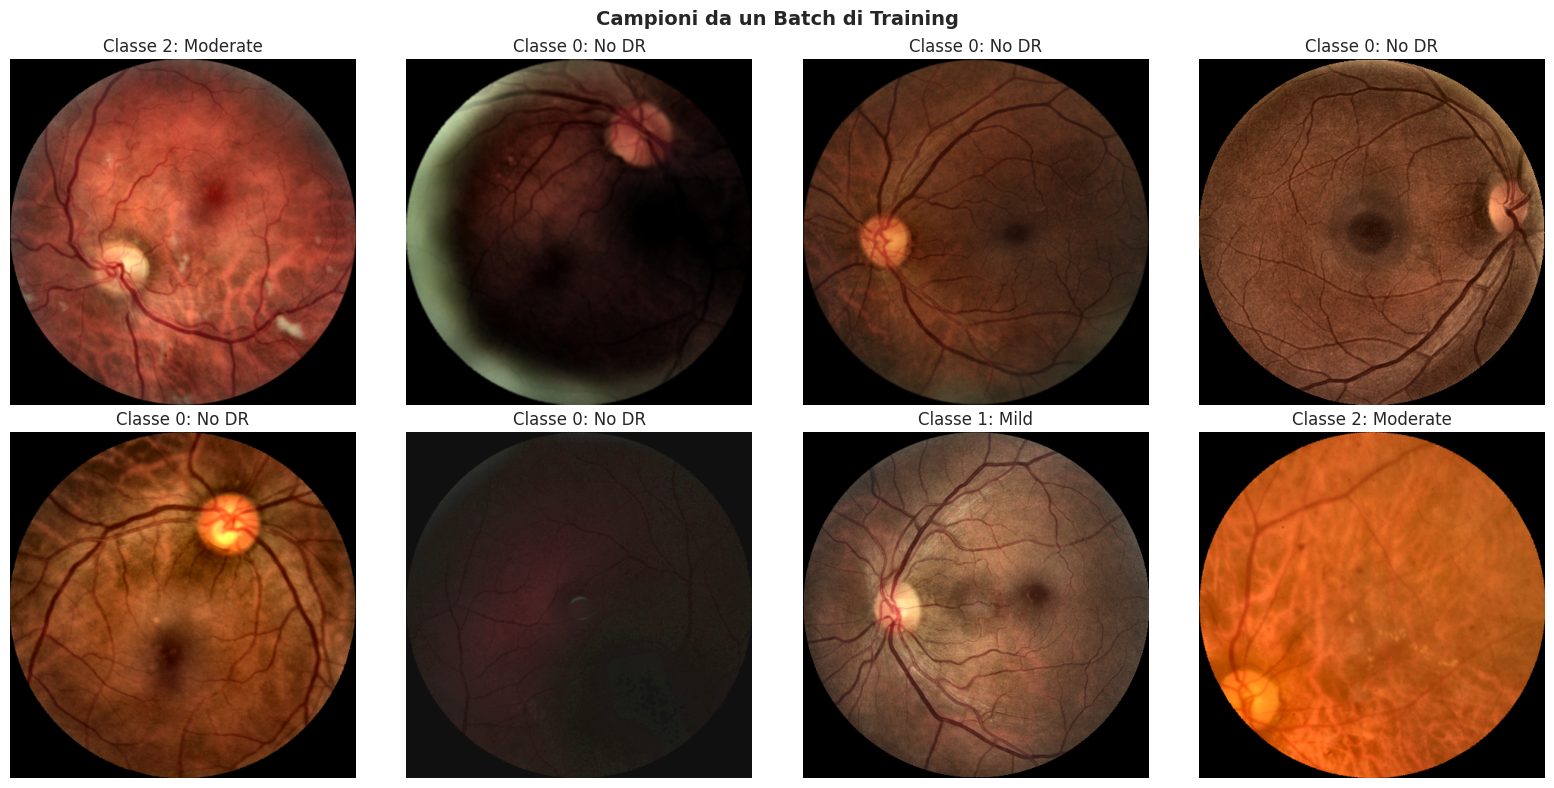

In [37]:
# Visualizza alcune immagini del batch
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, ax in enumerate(axes.flat):
    if i < len(batch_images):
        img = denormalize(batch_images[i])
        img_np = img.permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)
        
        label = batch_labels[i].item()
        ax.imshow(img_np)
        ax.set_title(f'Classe {label}: {class_names[label]}')
        ax.axis('off')

plt.suptitle('Campioni da un Batch di Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Verifica Distribuzione con Weighted Sampler

In [38]:
# Simula alcuni batch per verificare la distribuzione delle classi
def check_batch_distribution(loader, n_batches=100):
    """
    Verifica la distribuzione delle classi nei primi n batch.
    """
    all_labels = []
    
    for i, (_, labels) in enumerate(loader):
        if i >= n_batches:
            break
        all_labels.extend(labels.tolist())
    
    # Conta le occorrenze
    unique, counts = np.unique(all_labels, return_counts=True)
    
    print(f"Distribuzione nei primi {n_batches} batch ({len(all_labels)} campioni):")
    for cls, count in zip(unique, counts):
        pct = count / len(all_labels) * 100
        print(f"  Classe {cls} ({class_names[cls]}): {count} ({pct:.1f}%)")
    
    return dict(zip(unique, counts))

# Verifica
print("Distribuzione originale nel training set:")
for cls in range(5):
    count = (train_labels == cls).sum()
    pct = count / len(train_labels) * 100
    print(f"  Classe {cls}: {pct:.1f}%")

print("\n" + "="*50 + "\n")
batch_dist = check_batch_distribution(train_loader, n_batches=100)

Distribuzione originale nel training set:
  Classe 0: 71.6%
  Classe 1: 7.2%
  Classe 2: 16.0%
  Classe 3: 2.7%
  Classe 4: 2.5%


Distribuzione nei primi 100 batch (1600 campioni):
  Classe 0 (No DR): 1144 (71.5%)
  Classe 1 (Mild): 119 (7.4%)
  Classe 2 (Moderate): 255 (15.9%)
  Classe 3 (Severe): 40 (2.5%)
  Classe 4 (Proliferative): 42 (2.6%)


## 10. Salvataggio Oggetti per il Training

In [39]:
# Salva i class weights per uso nei prossimi notebook
torch.save(class_weights, PROCESSED_DIR / 'class_weights.pt')
print(f"Class weights salvati in: {PROCESSED_DIR / 'class_weights.pt'}")

Class weights salvati in: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data/processed/class_weights.pt


In [40]:
# Riepilogo finale
print("\nRiepilogo DataLoader")
print("=" * 50)
print(f"Training set: {len(train_dataset):,} immagini")
print(f"Validation set: {len(val_dataset):,} immagini")
print(f"Test set: {len(test_dataset):,} immagini")
print(f"\nBatch size: {batch_size}")
print(f"Num workers: {num_workers}")
print(f"Class weights: {class_weights.tolist()}")
print(f"\nAugmentation attive: flip, rotazione, colore, blur, rumore")


Riepilogo DataLoader
Training set: 38,056 immagini
Validation set: 366 immagini
Test set: 1,744 immagini

Batch size: 16
Num workers: 4
Class weights: [0.27937161922454834, 2.7747721672058105, 1.2477376461029053, 7.411100387573242, 8.079830169677734]

Augmentation attive: flip, rotazione, colore, blur, rumore


## 11. Conclusioni

### Componenti Creati

1. **DRDataset**: Classe Dataset PyTorch per caricare le immagini preprocessate
2. **Data Augmentation**: Pipeline Albumentations con trasformazioni geometriche e di colore
3. **Class Weights**: Pesi calcolati per bilanciare la Focal Loss
4. **DataLoader**: Loader pronti per training, validation e test

### Prossimi Passi

1. Implementazione del modello EfficientNet-B5
2. Implementazione della Focal Loss con Label Smoothing
3. Training loop con early stopping